# Тема 'RAG для миграции pyTorch с v1.0.0 на v2.7.0' 

## Настройка для использования

In [1]:
from logs.logging_setup import configure_logging
configure_logging()
import logging
LOGGER = logging.getLogger(__name__)

from validator import Validator
from retrival import Retreiver, get_embedding_core
from llm import get_llm_response, clean_llm_code
import pandas as pd

LLM_NAME = "tngtech/deepseek-r1t2-chimera"

# =========  Загрузка модели =================
model, tokenizer, model_config = get_embedding_core()
LOGGER.info(f"Модель {model_config.model_key} загружена")

# =========  Подключение к БД =================
rtr = Retreiver(model, "migTorch")
LOGGER.info(f"БД подключена")

# =========  Инициализация валидатора =================
val = Validator()

def run_test(code: str, env_version: str):
    '''
        Проверка работает ли код на версии env_version
    '''
    out, err = val.dynamic_val(code, torch_version=env_version)
    works = (err == '')
    return works, out, err

def RAG_get_new_code(code, model_name: str = "deepseek/deepseek-chat:free"):
    '''
        Получаем новый код после прогана в RAG
    '''
    prompt = rtr.build_prompt(code)
    LOGGER.info(f"Запрос в БД успешно выполнен")

    result = get_llm_response(prompt, model_name=model_name)
    LOGGER.info(f"Запрос в LLM успешно выполнен")

    result_code = clean_llm_code(result)
    LOGGER.info(f"Получен код из ответа LLM")

    return result_code


def testing(name, test_code, model_name:str = "deepseek/deepseek-chat:free"):
    LOGGER.info(f"[START TEST] {name}")
    
    works_100, out_100, err_100 = run_test(test_code, '1.0.0')
    LOGGER.info(f"{name} в 1.0.0: {'Работает' if works_100 else 'Не работает'}")
    LOGGER.debug(f"{name} в 1.0.0: {'Работает' if works_100 else 'Не работает'} | Out: {out_100} | Err: {err_100}")
    
    # Тест для 2.7.0
    works_270, out_270, err_270 = run_test(test_code, '2.7.0')
    LOGGER.info(f"{name} в 2.7.0: {'Работает' if works_270 else 'Не работает'}")
    LOGGER.debug(f"{name} в 2.7.0: {'Работает' if works_270 else 'Не работает'} | Out: {out_270} | Err: {err_270}")
    
    # Тест для ответа LLM
    new_code = RAG_get_new_code(test_code, model_name)
    new_code_works, new_code_out, new_code_err = run_test(new_code, '2.7.0')
    LOGGER.info(f"Вариант предложенный RAG в 2.7.0: {'Работает' if new_code_works else 'Не работает'}")
    LOGGER.debug(f"Вариант предложенный RAG в 2.7.0: {'Работает' if new_code_works else 'Не работает'} | Out: {new_code_out} | Err: {new_code_err}")
    
    LOGGER.info(f"[END TEST] {name}")

    return {
        'API': name,
        'Работает в 1.0.0': works_100,
        'Out 1.0.0': out_100,
        'Err 1.0.0': err_100,
        'Работает в 2.7.0': works_270,
        'Out 2.7.0': out_270,
        'Err 2.7.0': err_270[:200], # Пока что не придумал как хранить ошибки (в пандас есть ограничение по размеру)
        'Работает в 2.7.0 (после RAG)': new_code_works, 
        'RAG Out 2.7.0': new_code_out,
        'RAG Err 2.7.0': new_code_err,
    }, {
       'old_code': test_code,
        'new_code': new_code
    }


c:\Miniconda3\envs\migratetorch_rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-22 17:29:47,010 | INFO     | __main__ | Модель mini загружена
2025-07-22 17:29:47,388 | INFO     | __main__ | БД подключена


**Что такое RAG**

RAG (Retrieval Augmented Generation) — это метод работы с большими языковыми моделями, когда пользователь пишет свой вопросы, а мы программно к этому вопросу «подмешиваете» дополнительную информацию из каких‑то внешних источников и подаём все целиком на вход языковой модели. Другими словами мы говорим, то о чём наша модель может не знать или "забыть" это учесть.

**Давайте разберём на примере:**

*Пользователь*: Какой должен быть шрифт у кода при написании дипломной работы в ОГУ? 

LLM это не знает с вероятностью почти в 100% и тут появляется несколько исходов у LLM.
1) Сказать честно, что она не знает
2) Придумать свой вариант
3) Найти из интернета, но не факт, что она обратится к нужному источнику для поиска информации.

И тут на помощь приходит RAG, он дополняет вопрос пользователя. И поможет LLM ответить правильно.

**Почему такая тема?**

(Да)

## Что он может(на данный момент)?

In [2]:
name = "torch._six"
code = """import torch
B = torch.tensor([[1.0], [2.0]])
U = torch.tensor([[1.0, 2.0], [0.0, 1.0]])
result = torch.potrs(B, U)
print('OK')"""

dict_info, dict_code= testing('my_first_test', code, LLM_NAME)

print('='*30)
print('Old code:\n',dict_code['old_code'])
print('='*30)
print('New code:\n',dict_code['new_code'])
print('='*30)

pd.DataFrame(dict_info, index=['Test'])

2025-07-22 17:29:47,399 | INFO     | __main__ | [START TEST] my_first_test
2025-07-22 17:29:54,495 | INFO     | __main__ | my_first_test в 1.0.0: Работает
2025-07-22 17:30:05,992 | ERROR    | validator | Oшибка при исполнении code: Traceback (most recent call last):
  File "C:\Users\sinde\AppData\Local\Temp\tmpop5x9k5u.py", line 4, in <module>
    result = torch.potrs(B, U)
             ^^^^^^^^^^^
  File "C:\Miniconda3\envs\torch270\Lib\site-packages\torch\__init__.py", line 2688, in __getattr__
    raise AttributeError(f"module '{__name__}' has no attribute '{name}'")
AttributeError: module 'torch' has no attribute 'potrs'

ERROR conda.cli.main_run:execute(127): `conda run python C:\Users\sinde\AppData\Local\Temp\tmpop5x9k5u.py` failed. (See above for error)
2025-07-22 17:30:05,993 | INFO     | __main__ | my_first_test в 2.7.0: Не работает
2025-07-22 17:30:06,106 | INFO     | __main__ | Запрос в БД успешно выполнен
2025-07-22 17:30:37,202 | INFO     | __main__ | Запрос в LLM успешно 

Old code:
 import torch
B = torch.tensor([[1.0], [2.0]])
U = torch.tensor([[1.0, 2.0], [0.0, 1.0]])
result = torch.potrs(B, U)
print('OK')
New code:
 import torch
B = torch.tensor([[1.0], [2.0]])
U = torch.tensor([[1.0, 2.0], [0.0, 1.0]])
result = torch.cholesky_solve(B, U, upper=True)
print('OK')


,API,Работает в 1.0.0,Out 1.0.0,Err 1.0.0,Работает в 2.7.0,Out 2.7.0,Err 2.7.0,Работает в 2.7.0 (после RAG),RAG Out 2.7.0,RAG Err 2.7.0
Test,my_first_test,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,


## Обзор архитектуры

**Откуда мы брали данные и почему именно эти данные?**

Прежде чем приступать к архитектуре, давайте так же затронем не мало важную тему.

СБОР ДАННЫХ!!


Да, сбор данных это одна из важнейших ступеней в построении хорошей RAG системы. А всё потому что вы можете сделать ЛУЧШУЮ архитектуру, ЛУЧШИЕ методы поиска информации, ЛУЧШАЯ LLM, ЛУЧШИЙ промт, ЛУЧШИЙ UI... Ну ладно UI это конечно лишние.


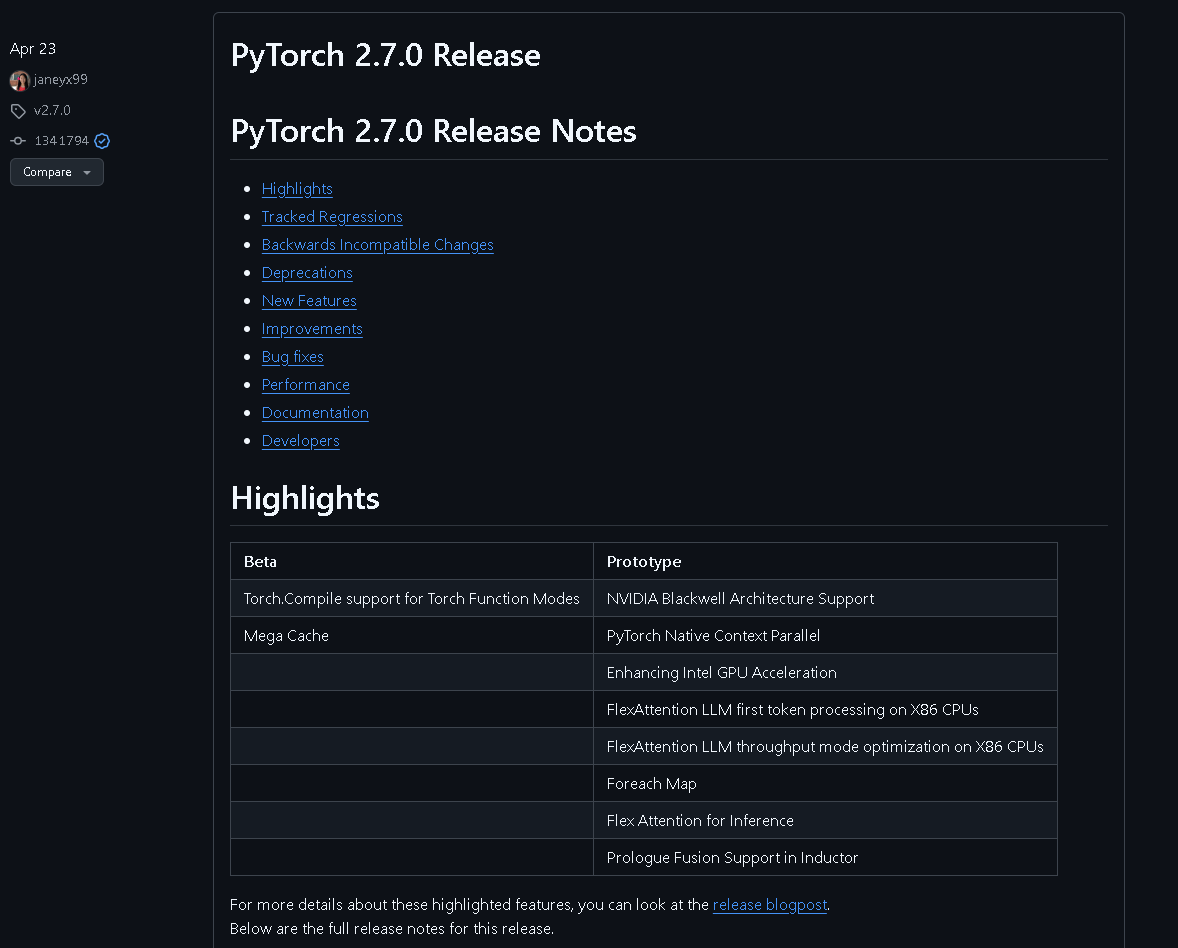

Все данные для создания контекста мы взяли из рилизов опубликованных на [gitHub](https://github.com/pytorch/pytorch/releases)


Они идеально подходят для нашей задачи, так как в рилизах прописываются изменения api, а так же есть примеры написания кода, а так же прописывается номер версии. 

*Идея на будущее: Можно добавить документацию по каждой из верссий. Это даст больший контекст.*


Основные компоненты RAG:
* Retrieval (извлечение): Как система ищет релевантные данные (например, векторная БД как Pinecone или FAISS).
* Augmentation (обогащение): Как извлечённые данные добавляются в промпт для LLM.
* Generation (генерация): Как LLM (например, GPT или Llama) создаёт ответ на основе обогащённого промпта.

Стэк технологий

## Что можно улучшить?

## Практика и метрики

In [3]:
TESTS_DICT = {
    'torch._six': "import torch._six; print('OK')",
    'torch.qr': "import torch; result = torch.qr(torch.tensor([[1.0, 2.0], [3.0, 4.0]])); print('OK')",
    'torch.autograd.function.traceable': "import torch.autograd.function; print(hasattr(torch.autograd.function.Function, 'traceable'))",
    'torch.testing.make_non_contiguous': "import torch.testing; t = torch.tensor([1.0]); non_cont = torch.testing.make_non_contiguous(t); print('OK')",
    'torch.gesv': "import torch; A = torch.tensor([[1.0, 2.0], [3.0, 4.0]]); B = torch.tensor([[5.0], [6.0]]); result = torch.gesv(B, A); print('OK')",
    'torch.potri': "import torch; A = torch.tensor([[1.0, 0.0], [0.0, 1.0]]); result = torch.potri(A); print('OK')",
    'torch.potrs': "import torch; B = torch.tensor([[1.0], [2.0]]); U = torch.tensor([[1.0, 2.0], [0.0, 1.0]]); result = torch.potrs(B, U); print('OK')",
    'torch.trtrs': "import torch; B = torch.tensor([[1.0], [2.0]]); A = torch.tensor([[1.0, 2.0], [0.0, 1.0]]); result = torch.trtrs(B, A); print('OK')",
    'torch.solve': "import torch; A = torch.tensor([[1.0, 2.0], [3.0, 4.0]]); B = torch.tensor([[5.0], [6.0]]); result = torch.solve(B, A); print('OK')",
    'torch.cholesky_solve': "import torch; B = torch.tensor([[1.0], [2.0]]); U = torch.tensor([[1.0, 2.0], [0.0, 1.0]]); result = torch.cholesky_solve(B, U); print('OK')",
    'torch.testing.make_tensor (low==high)': "import torch.testing; t = torch.testing.make_tensor(5, low=1.0, high=1.0, dtype=torch.float32); print('OK')", 
    'torch.nn.Module.register_backward_hook': "import torch.nn as nn; m = nn.Linear(1,1); hook = lambda module, grad_input, grad_output: print('OK'); m.register_backward_hook(hook); print('OK')", 
    'torch._export.capture_pre_autograd_graph': "from torch._export import capture_pre_autograd_graph; import torch; def f(x): return x * 2; captured = capture_pre_autograd_graph(f, (torch.tensor(1.0),)); print('OK')",
    'torch.distributed.init_process_group (old backend)': "import torch.distributed as dist; dist.init_process_group(backend='gloo', init_method='tcp://127.0.0.1:12345', world_size=1, rank=0); print('OK')", 
    'torch.optim.LBFGS (old params)': "import torch; import torch.optim as optim; params = [torch.tensor([1.0])]; optimizer = optim.LBFGS(params, lr=0.01); print('OK')",  
    'torch.linalg.qr': "import torch; a = torch.randn(3,3); q, r = torch.linalg.qr(a); print('OK')",
    'torch.linalg.solve': "import torch; a = torch.randn(3,3); b = torch.randn(3,1); solution = torch.linalg.solve(a, b); print('OK')",
    'torch.linalg.cholesky_inverse': "import torch; a = torch.randn(3,3); pos_def = a @ a.t() + torch.eye(3); chol = torch.linalg.cholesky(pos_def); inv = torch.linalg.cholesky_inverse(chol); print('OK')",
    'torch.triangular_solve': "import torch; a = torch.triu(torch.randn(3,3)); b = torch.randn(3,1); solution, cloned_a = torch.triangular_solve(b, a); print('OK')",
    'torch.export.export': "import torch; def f(x): return x * 2; exported = torch.export.export(f, (torch.tensor(1.0),)); print('OK')",
    'torch.distributed.init_process_group (nccl backend)': "import torch.distributed as dist; dist.init_process_group(backend='nccl', init_method='tcp://127.0.0.1:12346', world_size=1, rank=0); print('OK')"
}

In [8]:
info_dicts = []
code_dicts = []

for api_name, test_code in TESTS_DICT.items():
    info_dict, code_dict = testing(api_name, test_code, "tngtech/deepseek-r1t2-chimera")
    info_dicts.append(info_dict)
    code_dicts.append(code_dict)
    

2025-07-22 17:51:17,554 | INFO     | __main__ | [START TEST] torch._six
2025-07-22 17:51:24,508 | INFO     | __main__ | torch._six в 1.0.0: Работает
2025-07-22 17:51:34,657 | ERROR    | validator | Oшибка при исполнении code: Traceback (most recent call last):
  File "C:\Users\sinde\AppData\Local\Temp\tmph43ch0la.py", line 1, in <module>
    import torch._six; print('OK')
    ^^^^^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'torch._six'

ERROR conda.cli.main_run:execute(127): `conda run python C:\Users\sinde\AppData\Local\Temp\tmph43ch0la.py` failed. (See above for error)
2025-07-22 17:51:34,658 | INFO     | __main__ | torch._six в 2.7.0: Не работает
2025-07-22 17:51:34,695 | INFO     | __main__ | Запрос в БД успешно выполнен
2025-07-22 17:52:00,905 | INFO     | __main__ | Запрос в LLM успешно выполнен
2025-07-22 17:52:00,909 | INFO     | __main__ | Получен код из ответа LLM
2025-07-22 17:52:10,898 | INFO     | __main__ | Вариант предложенный RAG в 2.7.0: Работает
2025-07-22 17:5

### Метрики

In [9]:
dfTest = pd.DataFrame(info_dicts)
dfTest

,API,Работает в 1.0.0,Out 1.0.0,Err 1.0.0,Работает в 2.7.0,Out 2.7.0,Err 2.7.0,Работает в 2.7.0 (после RAG),RAG Out 2.7.0,RAG Err 2.7.0
0,torch._six,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
1,torch.qr,True,OK,,False,OK,C:\Users\sinde\AppData\Local\Temp\tmpbvp53fd9....,True,OK,
2,torch.autograd.function.traceable,True,False,,True,False,,True,False,
3,torch.testing.make_non_contiguous,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
4,torch.gesv,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
5,torch.potri,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
6,torch.potrs,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
7,torch.trtrs,True,OK,,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
8,torch.solve,False,,"Traceback (most recent call last):\n File ""C:...",False,,"Traceback (most recent call last):\n File ""C:...",True,OK,
9,torch.cholesky_solve,False,,"Traceback (most recent call last):\n File ""C:...",True,OK,,True,OK,


In [10]:
сount_test = len(dfTest)

count_works_1_0 = dfTest['Работает в 1.0.0'].sum()
count_works_2_7 = dfTest['Работает в 2.7.0'].sum()
count_rag_2_7 = dfTest['Работает в 2.7.0 (после RAG)'].sum()

pct_works_1_0 = (count_works_1_0 / сount_test) * 100
pct_works_2_7 = (count_works_2_7 / сount_test) * 100
pct_rag_2_7 = (count_rag_2_7 / сount_test) * 100

print("Анализ нашей работы:")
print(f"Всего тестов: {сount_test}")
print("Итог:")
print(f"\tРаботает в 1.0.0: {count_works_1_0} ({pct_works_1_0:.2f}%)")
print(f"\tРаботает в 2.7.0 (Без изменнений): {count_works_2_7} ({pct_works_2_7:.2f}%)")
print(f"\tРаботает в 2.7.0 (После работы RAG): {count_rag_2_7} ({pct_rag_2_7:.2f}%)")

Анализ нашей работы:
Всего тестов: 21
Итог:
	Работает в 1.0.0: 10 (47.62%)
	Работает в 2.7.0 (Без изменнений): 6 (28.57%)
	Работает в 2.7.0 (После работы RAG): 15 (71.43%)
